## GANs : Generative Adversarial Networks 


Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. Generative Adversarial Networks. NIPS, 2014. [PDF](https://arxiv.org/pdf/1406.2661v1.pdf)

Project for Computer Vision with Professor Vondrick, Columbia University

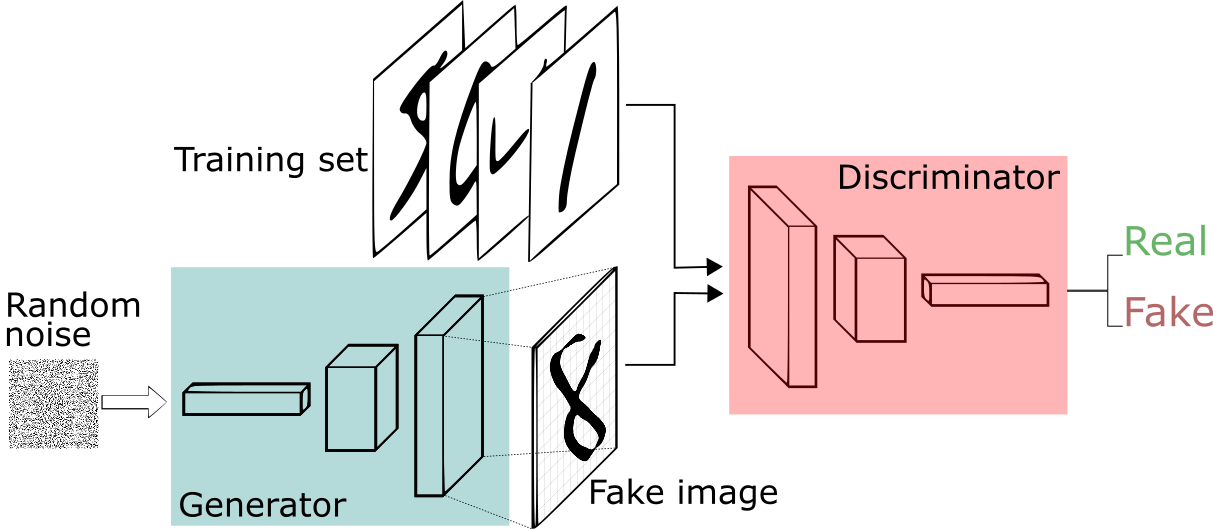

A generative adversarial network (GAN) is a generative model composed of two neural networks: a generator and a discriminator. These two networks are trained in unsupervised way via competition. The generator creates ”realistic” fake images from random noise to fool the discriminator, while the discriminator evaluates the given image for authenticity. 
The loss function that the generator wants to minimize and the discriminator to maximize is as follows: 

min G max D L(D, G) = Ex∼pdata(x)[log D(x)] + Ez∼pz(z)[log(1 − D(G(z)))] 

Here, G and D are the generator and the discriminator. The first and second term of the loss represent the correct prediction of the discriminator on the real images and on the fake images respectively. 




## DCGAN

We will implement deep convolutional GAN model on the MNIST dataset with Pytorch. The input image size is 28 x 28. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# image input size
image_size=28

# Setting up transforms to resize and normalize 
transform=transforms.Compose([
                               transforms.ToTensor(),
      ## Normalization for the dataset: 
      ## Normalize the image into [-1,1] range. This is recommended as the tanh function produces output in this range.
      transforms.Normalize(mean=[0.5], std=[0.5])
                               ])
# batchsize of dataset
batch_size = 100

# Load MNIST Dataset
gan_train_dataset = datasets.MNIST(root='./MNIST/', train=True, transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 160970846.65it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 54345309.03it/s]


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67920052.21it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1148867.98it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw




## 1. Model Definition

In [2]:
from torch.nn.modules.conv import ConvTranspose2d
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 128, kernel_size=5),
            nn.LeakyReLU(0.2, True),
            
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(128, 64, kernel_size=3),
            nn.LeakyReLU(0.2, True),

            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(64, 32, kernel_size=3),
            nn.LeakyReLU(0.2, True),

            nn.ConvTranspose2d(32, 1, kernel_size=3),
            nn.Tanh()
        )
        

    def forward(self, input):
        out = self.gen(input)
        return out


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 1, kernel_size=3),
            nn.Sigmoid()

        )
        
    
    def forward(self, input):
        out = self.disc(input).view(-1, 1)
        return out


# Code that check size
g=DCGAN_Generator()
batchsize=2
z=torch.zeros((batchsize, 100, 1, 1))
out = g(z)
print(out.size()) # You should expect size [batchsize, 1, 28, 28]



d=DCGAN_Discriminator()
x=torch.zeros((batchsize, 1, 28, 28))
out = d(x)
print(out.size()) # You should expect size [batchsize, 1]

torch.Size([2, 1, 28, 28])
torch.Size([2, 1])


## 2. GAN loss

In [18]:
import torch

def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion, optimizerD):

    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images (and detach the gradient from the fake images using detach())
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''
    D.zero_grad()
    d_real_out = D(real).view(-1)
    d_real_err = criterion(d_real_out, Valid_label)
    d_real_err.backward()

    g_out = G(noise)
    d_fake_out = netD(g_out.detach()).view(-1)
    d_fake_err = criterion(d_fake_out, Fake_label)
    d_fake_err.backward()

    loss_D = d_real_err + d_fake_err
    fake_imgs = g_out

    optimizerD.step()

    return loss_D, fake_imgs

def loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    netG.zero_grad()

    d_fake_out = netD(fake).view(-1)
    loss_G = criterion(d_fake_out, Valid_label)
    loss_G.backward()

    optimizerG.step()

    return loss_G

## 3. Training 

In [19]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

from torchsummary import summary
print(summary(netG,(100,1,1)))
print(summary(netD,(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 5, 5]         320,128
         LeakyReLU-2            [-1, 128, 5, 5]               0
UpsamplingBilinear2d-3          [-1, 128, 10, 10]               0
   ConvTranspose2d-4           [-1, 64, 12, 12]          73,792
         LeakyReLU-5           [-1, 64, 12, 12]               0
UpsamplingBilinear2d-6           [-1, 64, 24, 24]               0
   ConvTranspose2d-7           [-1, 32, 26, 26]          18,464
         LeakyReLU-8           [-1, 32, 26, 26]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]             289
             Tanh-10            [-1, 1, 28, 28]               0
Total params: 412,673
Trainable params: 412,673
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.91
Params size (MB): 1.57
Estimat

[0/10][0/600]	Loss_D: 1.3919	Loss_G: 0.6953	
[0/10][50/600]	Loss_D: 0.7510	Loss_G: 1.3380	
[0/10][100/600]	Loss_D: 0.8838	Loss_G: 0.9183	
[0/10][150/600]	Loss_D: 0.9454	Loss_G: 1.3381	
[0/10][200/600]	Loss_D: 0.9590	Loss_G: 0.8907	
[0/10][250/600]	Loss_D: 1.0400	Loss_G: 0.9440	
[0/10][300/600]	Loss_D: 1.1908	Loss_G: 0.9292	
[0/10][350/600]	Loss_D: 1.1621	Loss_G: 0.8566	
[0/10][400/600]	Loss_D: 1.2242	Loss_G: 0.9367	
[0/10][450/600]	Loss_D: 1.2649	Loss_G: 0.7489	
[0/10][500/600]	Loss_D: 1.1918	Loss_G: 0.8883	
[0/10][550/600]	Loss_D: 1.1675	Loss_G: 0.8198	
[1/10][0/600]	Loss_D: 1.1818	Loss_G: 0.6120	
[1/10][50/600]	Loss_D: 1.1242	Loss_G: 1.0529	
[1/10][100/600]	Loss_D: 1.0727	Loss_G: 0.8146	
[1/10][150/600]	Loss_D: 1.0748	Loss_G: 1.0856	
[1/10][200/600]	Loss_D: 1.1183	Loss_G: 0.6780	
[1/10][250/600]	Loss_D: 1.2084	Loss_G: 0.9017	
[1/10][300/600]	Loss_D: 1.1418	Loss_G: 1.0341	
[1/10][350/600]	Loss_D: 1.3035	Loss_G: 0.4863	
[1/10][400/600]	Loss_D: 1.0741	Loss_G: 0.9332	
[1/10][450/600]	Los

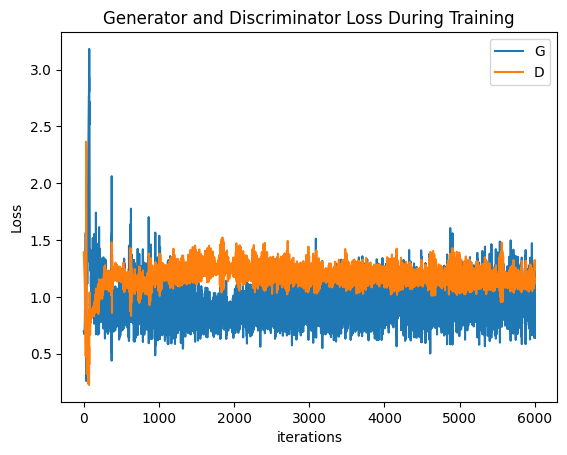

In [20]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D

optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))




img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 10

  
def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        loss_D, fake_imgs = loss_discriminator(netD, real, netG, noise, Valid_label,
                                               Fake_label, criterion, optimizerD)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        loss_G = loss_generator(netD, netG, fake_imgs, Valid_label, criterion, optimizerG)

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'gan_{}.pt'.format(num_epochs))




## 4. Qualitative Visualisations

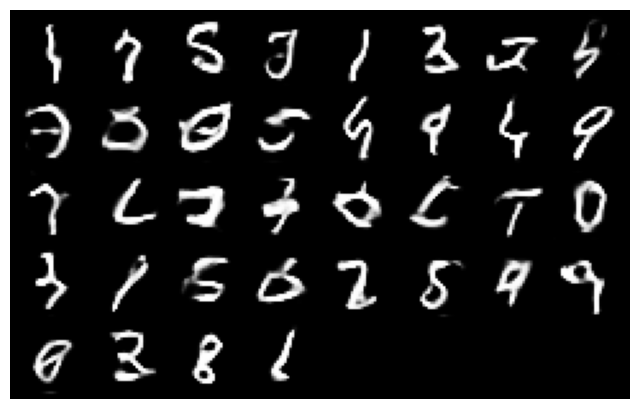

In [21]:
# Test GAN on a random sample and display on 6X6 grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())